## Aprendizado de maquina

Após feita a análise dos dados vamos tentar criar um modelo de predição dos dados utilizando bibliotecas de machine learning.


Será feito dois tipos de analises:
    
-**Receita por Produto, Local e data:** Vamos tentar indentificar um padrão de receita da receita da empresa por produto, assim será possivel prever a receita de um novo produto antes de sua venda, de um produto antigo sendo vendido em um local novo ou da receita de um produto em uma determinada data.

-**Projeção de Receita Futura:** Vamos aplicar um modelo de autoregressão para conseguir prever as receitas futuras da empresa.

Serão testados dois tipos de modelos, o primeiro serão modelos de **regressão**, tendo como resposta qual será o valor da receita do produto, o segundo um modelo de **classificação**, tendo como resposta como será a receita do produto entre 4 classes (muito alta, alta, media, baixa, muito baixa)

## Lendo os dados

In [1]:
#Importando bibliotecas nescessárias 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#importando SalesFacts
vendas = pd.read_csv('salesFacts.csv',delimiter='\t')
vendas.head()

#Lendo arquivo Dados de vendas
arq = pd.ExcelFile('Dados.xlsx')
arq.sheet_names

#Lendo tabelas do dos produtos, data, geografia e fabricante
products = pd.read_excel(arq,'Product')
manufacturer = pd.read_excel(arq,'Manufacturer')
geo = pd.read_excel(arq,'Geo')
date = pd.read_excel(arq,'Date')

# PrepData

### Retirando dados da VanArsdel

**Juntando dados da VanArsdel e Produtos**

In [3]:
vendas.head()

,ProductID,Date,Zip,Units,Revenue
0,88,15/02/2000 12:00:00 AM,95605,92,"$926,780.40"
1,2263,12/11/2008 12:00:00 AM,33178,44,"$177,380.28"
2,2262,12/11/2008 12:00:00 AM,33178,44,"$177,380.28"
3,764,27/07/2004 12:00:00 AM,27522,40,"$146,134.80"
4,763,27/07/2004 12:00:00 AM,27522,40,"$146,134.80"


In [4]:
products.head()

,Manufacturer,Category,Segment,Product,ProductID,isVanArsdel,IsCompeteHide,ManufacturerID,IsCompete
0,VanArsdel,Urban,Convenience,Maximus UC-01,536,Yes,N,7,No
1,VanArsdel,Urban,Convenience,Maximus UC-02,537,Yes,N,7,No
2,VanArsdel,Urban,Convenience,Maximus UC-03,538,Yes,N,7,No
3,VanArsdel,Urban,Convenience,Maximus UC-04,539,Yes,N,7,No
4,VanArsdel,Urban,Convenience,Maximus UC-05,540,Yes,N,7,No


In [5]:
vendasProduto = pd.merge(vendas,products,on='ProductID')

**Filtrando VanArsdel**

In [6]:
vendasProduto = vendasProduto[vendasProduto['isVanArsdel'] == 'Yes']

### Convertendo Receita para numerico

In [7]:
def tratarReceita(receita):
    if type(receita) == str:
        receita = receita.replace('$','').replace(',','')
        return float(receita)
vendasProduto['Revenue'] = vendasProduto['Revenue'].apply(tratarReceita)

### Convertendo tabela para serie temporal

In [8]:
from datetime import datetime
def convertData(data):
    return datetime.strptime(data,'%d/%m/%Y %H:%M:%S %p')
vendasProduto['Date'] = vendasProduto['Date'].apply(convertData)
vendasProduto = vendasProduto.set_index(vendasProduto['Date'])

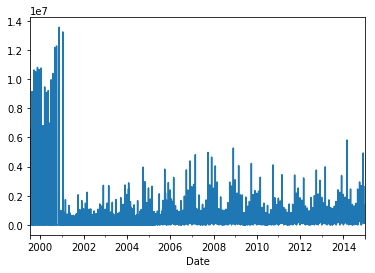

In [9]:
vendasGrupo = vendasProduto.groupby(pd.Grouper(freq='d')).sum()
vendasGrupo['Revenue'].plot()

### Juntandos os dados

# Receita Futura

### Reduzindo valores

Devido a grande quantidade de dados, vamos agrupa-los em dados diarios para diminuir seus valores

**Verificando autoCorrelação**

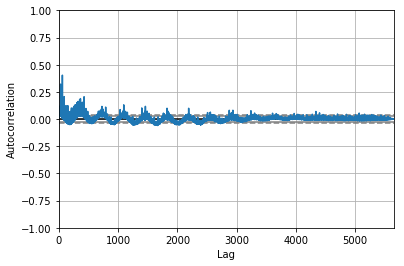

In [75]:
pd.plotting.autocorrelation_plot(vendasGrupo['Revenue'])

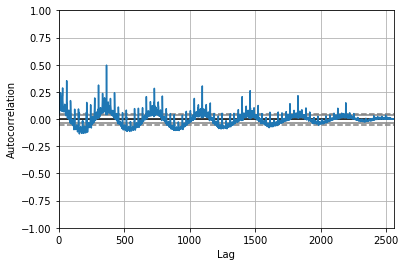

In [76]:
pd.plotting.autocorrelation_plot(vendasGrupo['2008':]['Revenue'])

### Fazendo modelo de autoRegressão

**Separando a cauda para testes**

In [81]:
y = vendasGrupo['Revenue']

In [88]:
pontoCorte = int(len(y)*0.66)
indexPC = y.index[pontoCorte]

In [91]:
yTreino = y[:str(indexPC)]
yTeste = y[str(indexPC):]

**Fazendo autoRegressão, StatsModels**

In [92]:
from statsmodels.tsa.ar_model import AR

In [100]:
modelo = AR(yTreino)
modelofit = modelo.fit()
previstos = modelofit.predict(start=len(yTreino),end=len(yTreino)+len(yTeste)-1)

C:\Users\vinic\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


**Calculando a Acuracia**

In [98]:
from sklearn.metrics import mean_absolute_error
error = previstos - yTeste
mean_absolute_error(previstos,yTeste)/y.mean()

0.5457739378727534

**Fazendo Arima**

In [103]:
from statsmodels.tsa.arima_model import ARIMA
#This sets the lag value to 5 for autoregression, 
#uses a difference order of 1 to make the time series stationary, 
#and uses a moving average model of 0
model = ARIMA(y, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.Revenue   No. Observations:                 5647
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -84536.102
Method:                       css-mle   S.D. of innovations         767631.100
Date:                Sat, 30 Mar 2019   AIC                         169086.204
Time:                        16:56:25   BIC                         169132.676
Sample:                    07-16-1999   HQIC                        169102.392
                         - 12-30-2014                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -687.7551   2980.219     -0.231      0.817   -6528.878    5153.368
ar.L1.D.Revenue    -0.7849      0.013    -59.701      0.000      -0.811      -0.759
ar.L2.D.Revenue    -0.6414      

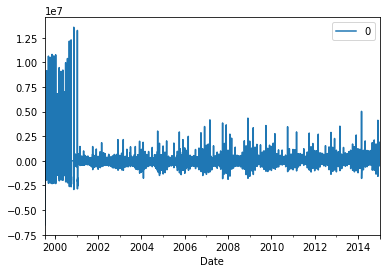

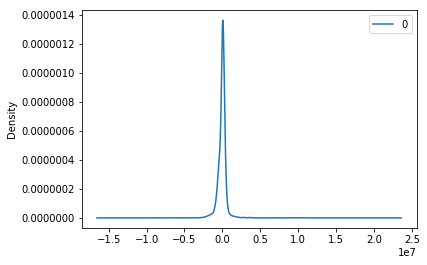

In [104]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [105]:
history = list(yTreino)
predictions = []
for valor in yTeste:
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    previsao = output[0]
    predictions.append(previsao)
    history.append(valor)

In [106]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(yTeste, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(yTeste)
plt.plot(predictions, color='red')

Test MSE: 211294509833.546


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000019538593F28> (for post_execute):


ValueError: view limit minimum -36779.85 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36779.85 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

# Receita por Produto, Local e data

In [ ]:
m